#  Assignment 6 by Haobin Tang

## 1. Implement Forward-View TD(Lambda) algorithm for Value Function Prediction

In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt

In [111]:
def Forward_TD(size,TD_path, Lambda, gamma, alpha="Not fixed"):
    V, counts_dict=env(size)

    for episode in TD_path:
        for j,i in enumerate(episode):
            _, G_lambda=get_G_lambda(j,episode,V,gamma,Lambda)
            s=i[0]
            counts_dict[s] += 1
            if alpha=="Not fixed":
                a = 1/counts_dict[s]
            else:
                a=alpha
            V[s] = V[s] + a*(G_lambda-V[s])
    return V 

In [42]:
def env(size):
    V={}
    counts_dict={}
    for i in range(size):
        V[i]=0
        counts_dict[i]=0
    return V, counts_dict

In [95]:
def get_G_lambda(j,episode,V,gamma,Lambda): 
    len_of_G=len(episode)-j
    G_n=[0]*len_of_G
    for k in range(j,len(episode)):
        for l in range(len_of_G):
            if l>=k-j:
                G_n[l]=G_n[l]+episode[k][1]*gamma**(k-j)
            if k<len(episode)-1:
                if l==k-j:
                    G_n[l]=G_n[l]+V[episode[k+1][0]]*gamma**(k-j+1)
    G_lambda=0
    for i in range(len(G_n)):
        if i<len(G_n)-1:
            G_lambda+=(1-Lambda)*(Lambda**i)*G_n[i]
        else:
            G_lambda+=(Lambda**i)*G_n[i]
    return G_n, G_lambda

In [118]:
#TD_path contains the data of episodes. Each episode there are (state, r) pairs.
TD_path=[
    [[0,5],[1,3],[3,2],[0,2],[5,2]],
    [[0,3],[2,3],[4,3]],
    [[1,6],[2,4],[4,3],[1,2],[5,2]],
    [[1,6],[3,4],[4,3],[3,2],[0,2]],
    [[1,6],[4,4],[4,3],[2,2],[1,2]],
    [[1,6],[3,4],[4,3],[3,2],[0,2]],
]

In [114]:
#test get_G_lambda()
episode=[0,5],[1,3],[3,2],[0,2],[5,2]
V={0: 1.0, 1: 2.0, 2: 2.0, 3: 3.0, 4: 2.0, 5: 1.0}
G_n, G_lambda=get_G_lambda(0,episode,V,0.9,0.1)
print("G_n is",G_n,'\n',"G_lambda=",G_lambda)

G_n is [6.8, 10.13, 10.049, 11.4341, 12.090200000000001] 
 G_lambda= 7.133640710000001


In [119]:
Forward_TD(6,TD_path, 0.1, 0.9,"Not fixed")

{0: 2.952417844,
 1: 8.028131271863701,
 2: 6.457651846334045,
 3: 7.418920907535256,
 4: 8.333474088554961,
 5: 2.0}

In [120]:
Forward_TD(6,TD_path, 0.1, 0.9,0.1)

{0: 1.1526921507242,
 1: 2.700754587058949,
 2: 1.0763228690358013,
 3: 1.582766047279178,
 4: 1.9367578567556742,
 5: 0.38}

## 2. Implement Backward View TD(Lambda), i.e., Eligibility Traces algorithm for Value Function Prediction

$$\delta_t=R_{t+1}+\gamma V(S_{t+1})-V(S_t)$$
$$V(s)=V(s)+\alpha \delta_t E_t(s)$$
When $\lambda = 0$, only current state is updated
$$E_t(s)=1(S_t=s)$$
$$V(s)=V(s)+\alpha \delta_t E_t(s)$$
$$V(s)=V(s)+\alpha \delta_t$$
When $\lambda = 1$, credit is deferred until end of episode,Over the course of an episode, total update for TD(1) is the same as total update for MC, which we have proved in class:

Consider an episode where s is visited once at time-step $k$,
TD(1) eligibility trace discounts time since visit,
$$E_t(s) = \gamma E_{t−1}(s) + 1(S_t = s)$$
$$E_t(s) =0 $$ if $t<k$
$$E_t(s) =\gamma^{t-k} $$ if $t>=k$

By end of episode it accumulates total error
$$\delta_k+\gamma\delta_{k+1}+\gamma^2\delta_{k+2}+\gamma^{T-k-1}\delta_{T-1}$$
$$=R_{t+1}+\gamma V(S_{t+1})-V(S_t)$$
$$+\gamma R_{t+2}+\gamma^2 V(S_{t+2})-\gamma V(S_{t+1})$$
$$...$$
$$+\gamma^{T-1-t} R_{T}+\gamma^{T-t} V(S_{T})-\gamma^{T-t-1} V(S_{T-1})$$
$$=R_{t+1}+\gamma R_{t+2}+...+\gamma^{T-1-t} R_{T}-V(S_t)$$
$$=G_t-V(S_t)$$

We prove Prove that Offline Forward-View TD(Lambda) and Offline Backward View TD(Lambda) are equivalent in problem 5.

In [141]:
# Offline update
def Backward_TD(size,TD_path, Lambda,gamma,alpha="Not fixed"):
    V, counts_dict=env(size)
    for episode in TD_path:
        G_lambda=get_G_lambda_list(episode,V,gamma,Lambda)
        for j,i in enumerate(episode):
            s=i[0]
            counts_dict[s] += 1
            if alpha=="Not fixed":
                a = 1/counts_dict[s]
            else:
                a=alpha
            V[s] = V[s] + a*(G_lambda[j])
    return V

In [78]:
def get_G_lambda_list(episode,V,gamma,Lambda): 
    G_lambda=[0]*len(episode)
    for j,i in enumerate(episode):
        s=i[0]
        r=i[1]
        if j<len(episode)-1:
            next_s=episode[j+1][0]
            delta_j=r+gamma*V[next_s]-V[s]
        else:
            delta_j=r-V[s]
        
        for k in range(0,j+1):
            G_lambda[k]+=delta_j*(Lambda*gamma)**(j-k)
    return G_lambda

In [79]:
#test get_G_lambda_list()
episode=[0,5],[1,3],[3,2],[0,2],[5,2]
V={0: 1.0, 1: 2.0, 2: 2.0, 3: 3.0, 4: 2.0, 5: 1.0}
G_lambda=get_G_lambda_list(episode,V,0.9,0.1)
print("G_lambda is",G_lambda)

G_lambda is [6.13364071, 3.7071190000000005, 0.07909999999999992, 1.99, 1.0]


In [121]:
TD_path=[
    [[0,5],[1,3],[3,2],[0,2],[5,2]],
    [[0,3],[2,3],[4,3]],
    [[1,6],[2,4],[4,3],[1,2],[5,2]],
    [[1,6],[3,4],[4,3],[3,2],[0,2]],
    [[1,6],[4,4],[4,3],[2,2],[1,2]],
    [[1,6],[3,4],[4,3],[3,2],[0,2]],
]

Backward_TD(6,TD_path, 0.1, 0.9)

{0: 4.009975688,
 1: 7.630804343210887,
 2: 6.015810307765591,
 3: 7.271754216045634,
 4: 6.753814199216089,
 5: 2.0}

In [122]:
Backward_TD(6,TD_path, 0.1, 0.9,0.1)

{0: 1.1912401341380001,
 1: 2.781332274429034,
 2: 1.0307742563655233,
 3: 1.6396252770882496,
 4: 1.8639807300758666,
 5: 0.38}

## 3. Implement these algorithms as offline or online algorithms (offline means updates happen only after a full simulation trace, online means updates happen at every time step)

We can see that from the above, there are slightly difference the forward and backward TD algorithms. The reason is that in my above design, the forward TD is online alogorithm, which use the V(s) updated in the same episode, while the forward TD is offline alogorithm, which use the V(s) updated from the last episode. We can see from the following example, where there is two state 0. In forward TD, the later state 0 use the updated $V(S_0)$ to calculate G, while in the backward TD, it uses the unchanged $V(S_0)$.  

In [125]:
TD_path=[
    [[0,5],[1,3],[3,2],[0,2],[5,2]]
]
print("Forward_TD",Forward_TD(6,TD_path, 0.1, 0.9))
print("Backward_TD",Backward_TD(6,TD_path, 0.1, 0.9))

Forward_TD {0: 3.73389461, 1: 3.5831378341380002, 2: 0, 3: 6.4793092682, 4: 0, 5: 2.0}
Backward_TD {0: 6.37778922, 1: 3.197658, 2: 0, 3: 2.1962, 4: 0, 5: 2.0}


If we just have an episode, which each state appear at most once, the result will be the same.

In [126]:
TD_path=[
    [[0,5],[1,3],[3,2],[4,2],[5,2]]
]
print("Forward_TD",Forward_TD(6,TD_path, 0.1, 0.9))
print("Backward_TD",Backward_TD(6,TD_path, 0.1, 0.9))

Forward_TD {0: 5.28778922, 1: 3.197658, 2: 0, 3: 2.1961999999999997, 4: 2.18, 5: 2.0}
Backward_TD {0: 5.2877892200000005, 1: 3.197658, 2: 0, 3: 2.1962, 4: 2.18, 5: 2.0}


Therefore, now I need to modify Forward_TD to offline version and Backward_TD to online version.

In [142]:
def Forward_TD_offline(size,TD_path, Lambda, gamma, alpha="Not fixed"):
    V, counts_dict=env(size)

    for episode in TD_path:
        G_lambda_list=[]
        for j,i in enumerate(episode):
            s=i[0]
            _, G_lambda=get_G_lambda(j,episode,V,gamma,Lambda)
            G_lambda_list.append(G_lambda-V[s])
        for j,i in enumerate(episode):
            s=i[0]
            counts_dict[s] += 1
            if alpha=="Not fixed":
                a = 1/counts_dict[s]
            else:
                a=alpha
            V[s] = V[s] + a*(G_lambda_list[j])
    return V

In [144]:
TD_path=[
    [[0,5],[1,3],[3,2],[0,2],[5,2]],
    [[0,3],[2,3],[4,3]],
    [[1,6],[2,4],[4,3],[1,2],[5,2]],
    [[1,6],[3,4],[4,3],[3,2],[0,2]],
    [[1,6],[4,4],[4,3],[2,2],[1,2]],
    [[1,6],[3,4],[4,3],[3,2],[0,2]],
]
print("Forward_TD_offline",Forward_TD_offline(6,TD_path, 0.1, 0.9))
print("Backward_TD",Backward_TD(6,TD_path, 0.1, 0.9))

Forward_TD_offline {0: 4.009975688, 1: 7.630804343210888, 2: 6.015810307765592, 3: 7.271754216045635, 4: 6.753814199216088, 5: 2.0}
Backward_TD {0: 4.009975688, 1: 7.630804343210887, 2: 6.015810307765591, 3: 7.271754216045634, 4: 6.753814199216089, 5: 2.0}


That's perfect!

Next, we modify the Backward_TD to online version.

In [145]:
def Backward_TD_online(size,TD_path, Lambda,gamma,alpha="Not fixed"):
    V, counts_dict=env(size)
    for episode in TD_path:
        for j,i in enumerate(episode):
            G_lambda=get_G_lambda_list(episode,V,gamma,Lambda)
            s=i[0]
            counts_dict[s] += 1
            if alpha=="Not fixed":
                a = 1/counts_dict[s]
            else:
                a=alpha
            V[s] = V[s] + a*(G_lambda[j])
    return V


In [147]:
TD_path=[
    [[0,5],[1,3],[3,2],[0,2],[5,2]],
    [[0,3],[2,3],[4,3]],
    [[1,6],[2,4],[4,3],[1,2],[5,2]],
    [[1,6],[3,4],[4,3],[3,2],[0,2]],
    [[1,6],[4,4],[4,3],[2,2],[1,2]],
    [[1,6],[3,4],[4,3],[3,2],[0,2]],
]
print("Forward_TD",Forward_TD(6,TD_path, 0.1, 0.9))
print("Backward_TD_online",Backward_TD_online(6,TD_path, 0.1, 0.9))

Forward_TD {0: 2.952417844, 1: 8.028131271863701, 2: 6.457651846334045, 3: 7.418920907535256, 4: 8.333474088554961, 5: 2.0}
Backward_TD_online {0: 2.952417844, 1: 8.028131271863701, 2: 6.457651846334045, 3: 7.418920907535255, 4: 8.333474088554961, 5: 2.0}


That's perfect too! For now, we have finished the online and offline version of Forward_TD and Backward_TD_online. 

## 4. Test these algorithms on some example MDPs, compare them versus DP Policy Evaluation, and plot their accuracy as a function of Lambda

In [197]:
MP_transistion_Data={
        0: {0:0.25, 1: 0.25, 2: 0.25, 3: 0.25},
        1: {0:0, 1: 0, 2: 0.5, 3: 0.5},
        2: {0:0, 1: 0.5, 2: 0, 3: 0.5},
        3: {0:0, 1: 0, 2: 0, 3:1},
    }

Reward={0:2.5,1:2,2:2,3:3}


In [192]:
MP_transistion_Data={
        0: {0:0.5, 1: 0.5},
        1: {0:0, 1: 1},

    }

Reward={0:1,1:1}

In [198]:
''' To simplify as an MRP, we use the DP value function evaluation in HW2 to compute value function.
The above algorithms are for (state, reward) pairs. Thus, the information of policy and state transition
probability is in the data.
'''
def Solve_V(MP_transistion_Data,Reward,gama):
    n=len(MP_transistion_Data)
    V_matrix=np.zeros((n,n))
    R_vector=np.zeros(n)
    all_one=np.eye(n)
    for i in range(n):
        for j in range(n):
            V_matrix[i][j]=MP_transistion_Data[i][j]*gama
    for i in range(n):
        R_vector[i]=Reward[i]
    
    Result=np.dot(R_vector,np.linalg.inv(all_one-np.transpose(V_matrix)))
    
    return Result

In [241]:
print("the result of value function is " )
print(Solve_V(MP_transistion_Data,Reward,0.9))

the result of value function is 
[28.29912023 28.18181818 28.18181818 30.        ]


In [179]:
trajectory=[
    [[0,2],[1,2],[2,2],[3,3]],
    [[0,2],[1,2],[2,2],[1,2],[3,3]],
    [[0,2],[1,2],[2,2],[1,2],[2,2],[3,3]],
    [[0,2],[1,2],[2,2],[1,2],[2,2],[1,2],[3,3]],
    [[0,2],[1,2],[2,2],[1,2],[2,2],[1,2],[2,2],[3,3]],
    [[0,2],[1,2],[3,3]],
    [[0,2],[2,2],[3,3]],
    [[0,2],[2,2],[1,2],[3,3]],
    [[0,2],[2,2],[3,3]],
    [[0,2],[2,2],[1,2],[2,2],[3,3]],
    [[0,2],[2,2],[1,2],[2,2],[1,2],[3,3]],
    [[0,2],[2,2],[1,2],[2,2],[1,2],[3,3]],
    [[0,2],[2,2],[1,2],[2,2],[1,2],[2,2],[3,3]],
    [[0,4],[3,3]],
]

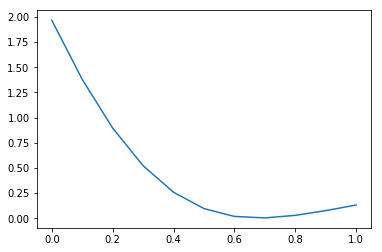

In [258]:
trueV=[8,7,7,3]
plot_Lambda=[]
plot_error=[]
for Lambda in range(0,11):
    result=Backward_TD(4,trajectory, Lambda/10, 0.9)
    accuracy=0
    for i in range(4):
        accuracy+=(result[i]-trueV[i])**2/4
    plot_Lambda.append(Lambda/10)
    plot_error.append(accuracy)

plt.plot(plot_Lambda,plot_error)

## 5. Prove that Offline Forward-View TD(Lambda) and Offline Backward View TD(Lambda) are equivalent. We covered the proof of Lambda = 1 in class. Do the proof for arbitrary Lambda (similar telescoping argument as done in class) for the case where a state appears only once in an episode.

For general $\lambda$, TD errors also telescope to $\lambda$-error, $G_t^λ − V(S_t)$
$$\begin{aligned}
G_t^\lambda − V(S_t)=− V(S_t)&+(1-\lambda)\lambda^0(R_{t+1}+\gamma V(S_{t+1})) \\
&+(1-\lambda)\lambda^1(R_{t+1}+\gamma R_{t+2}+\gamma^2 V(S_{t+2}))\\
&+(1-\lambda)\lambda^2(R_{t+1}+\gamma R_{t+2}+\gamma^2 R_{t+3}+\gamma^3 V(S_{t+3}))\\
&+...\\
=− V(S_t)&+(\gamma\lambda)^0(R_{t+1}+\gamma V(S_{t+1}-\gamma \lambda V(S_{t+1}))\\
&+(\gamma\lambda)^1(R_{t+2}+\gamma V(S_{t+2}-\gamma \lambda V(S_{t+2}))\\
&+(\gamma\lambda)^2(R_{t+3}+\gamma V(S_{t+3}-\gamma \lambda V(S_{t+3}))\\
&+...\\
=&(\gamma\lambda)^0(R_{t+1}+\gamma V(S_{t+1}- V(S_{t}))\\
&+(\gamma\lambda)^1(R_{t+2}+\gamma V(S_{t+2}- V(S_{t+1}))\\
&+(\gamma\lambda)^2(R_{t+3}+\gamma V(S_{t+3}- V(S_{t+2}))\\
&+...\\
&=\lambda_t+\gamma\lambda\delta_{t+1}+(\gamma\lambda)^2\delta_{t+2}+(\gamma\lambda)^{T}\delta_{T}
\end{aligned}$$